In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to create data generators
def create_generators(base_dir, target_size=(150, 150), batch_size=20):
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    
    return train_generator, validation_generator


In [2]:
def build_cnn_model(input_shape=(150, 150, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])
    return model


In [3]:
def build_transfer_learning_model(input_shape=(150, 150, 3)):
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    conv_base.trainable = False
    
    model = models.Sequential([
        conv_base,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])
    return model


In [4]:
def train_and_evaluate_model(model, train_generator, validation_generator, epochs=30):
    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=50
    )
    return history

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def plot_confusion_matrix(model, validation_generator):
    y_pred = model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = validation_generator.classes

    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/100 ━━━━━━━━━━━━━━━━━━━━ 1:13 750ms/step - accuracy: 0.5000 - loss: 0.7757

C:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5000 - loss: 0.8602 - val_accuracy: 0.5000 - val_loss: 0.7183
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5000 - loss: 0.7127 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4995 - loss: 0.6975 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3753 - loss: 0.6993 - val_accuracy: 0.6000 - val_loss: 0.6919
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5505 - loss: 0.6920 - val_accuracy: 0.5250 - val_loss: 0.6923
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5510 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5005 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5505 - loss: 0.6913 - val_accuracy: 0.500

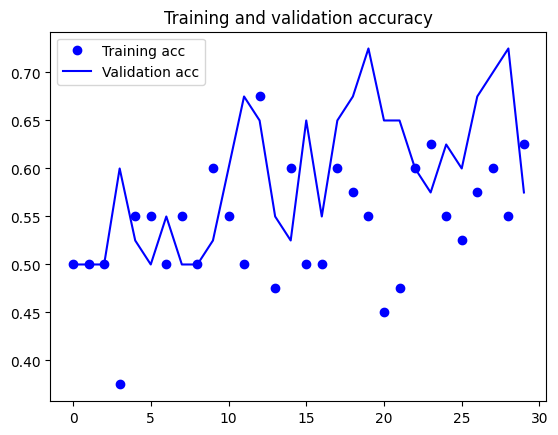

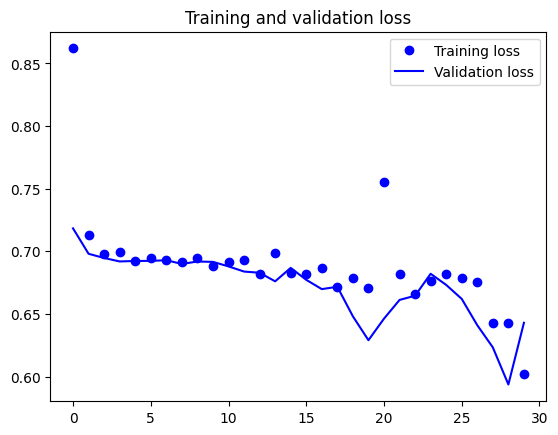

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step


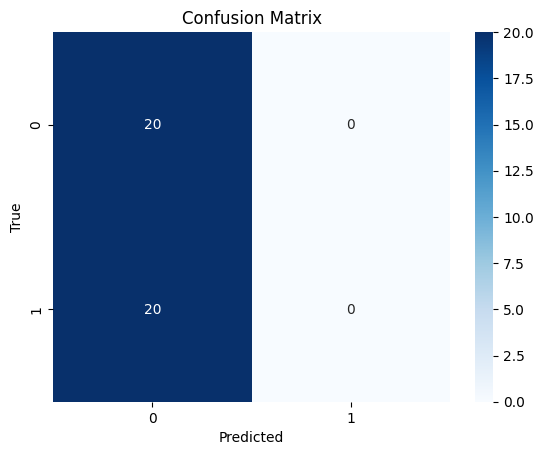

Epoch 1/30
  2/100 ━━━━━━━━━━━━━━━━━━━━ 7:16 4s/step - accuracy: 0.4750 - loss: 0.7078 

C:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.4995 - loss: 0.7066 - val_accuracy: 0.4750 - val_loss: 0.6874
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.5995 - loss: 0.6692 - val_accuracy: 0.7000 - val_loss: 0.6157
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.6495 - loss: 0.6300 - val_accuracy: 0.7000 - val_loss: 0.6203
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.6248 - loss: 0.6539 - val_accuracy: 0.7500 - val_loss: 0.6074
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.7500 - loss: 0.6153 - val_accuracy: 0.7000 - val_loss: 0.6156
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.7253 - loss: 0.5858 - val_accuracy: 0.7500 - val_loss: 0.5781
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.6490 - loss: 0.6223 - val_accuracy: 0.6750 - val_loss: 0.6050
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.6500 - loss: 0.6144 - val

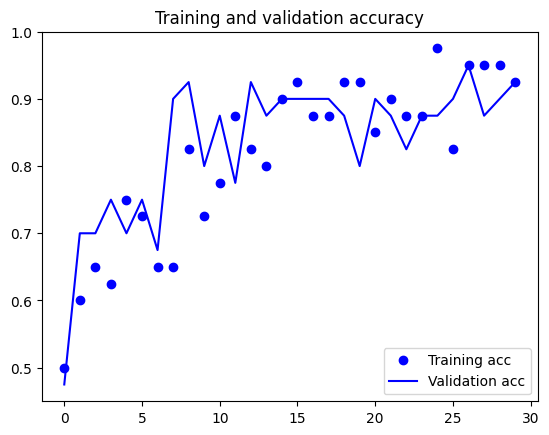

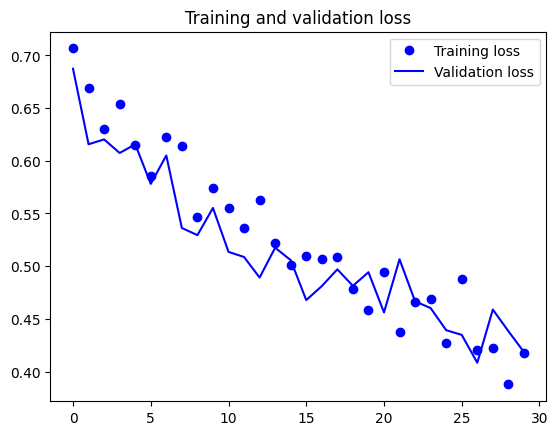

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


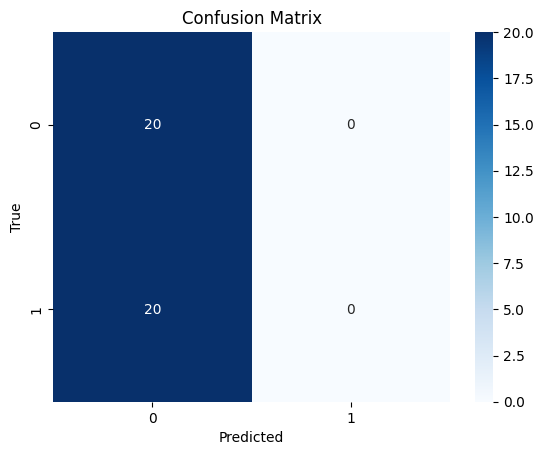

In [5]:
base_dir = 'D:\\Project\\dataset\\20_images'
train_gen, val_gen = create_generators(base_dir)

# CNN Model-
cnn_model = build_cnn_model()
cnn_history = train_and_evaluate_model(cnn_model, train_gen, val_gen)
plot_history(cnn_history)
plot_confusion_matrix(cnn_model, val_gen)

# Transfer Learning Model
tl_model = build_transfer_learning_model()
tl_history = train_and_evaluate_model(tl_model, train_gen, val_gen)
plot_history(tl_history)
plot_confusion_matrix(tl_model, val_gen)

